### IST 718 Week 4 Exercises
Using anonymous data from my job, I'll analyze the time series for disbursments between January and September 2018, trying to forecast disbursments for October through December. I'll then compare these forecasts to the actual disbursements. 

In [116]:
# Import packages 
import pandas as pd
from pandas import datetime
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [121]:
# Define a datetime parser that will convert date column to datetime
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

# Load Time Series data. 
df = pd.read_csv('TimeSeries.csv', parse_dates=[0], date_parser=parser)

# Split the data into January-September and October-December for analysis, forecasting, and comparison
jan_sep = df[df['disbursement_date'] <= '2018-09-30']
oct_dec = df[df['disbursement_date'] >= '2018-10-01']

In [122]:
# We'll check the shape of the three data sets to check that the data has been split correctly.
print('Time Series - Complete: ', df.shape)
print('Jan-Sep: ', jan_sep.shape)
print('Oct-Dec: ', oct_dec.shape)

Time Series - Complete:  (252, 3)
Jan-Sep:  (189, 3)
Oct-Dec:  (63, 3)


The data sets were split correctly. Now we'll do some quick data exploration for the jan_sep data set along with some graphs. 

In [123]:
# The data set consists of three columns: disbursement_date, disbursement_amount, and disbursements. These 
# last two columns show the total amount disbursed over each day and the number of loans disbursed each day.
print(jan_sep.head())

# Let's check the data type for each column to make sure we're dealing with a datetime variable, and two
# numeric variables. 
print(jan_sep.dtypes)

  disbursement_date  disbursement_amount  disbursements
0        2018-01-02              20083.8              6
1        2018-01-03              33903.0             13
2        2018-01-04              25543.4              9
3        2018-01-05              24190.3              8
4        2018-01-08              85065.0             25
disbursement_date      datetime64[ns]
disbursement_amount           float64
disbursements                   int64
dtype: object


Let's do some quick summarisation. We should check the distributions for both disbursement_amount and disbursements by month to check how much the data fluctuates.  
We should also plot how the data fluctuates on a daily basis. 

In [124]:
# Let's create a new variable, month, that will allow us to check distributions across the year.
jan_sep['month'] = jan_sep['disbursement_date'].dt.month

# Now we'll check the average disbursement_amount and disbursements per day by month. 
print(jan_sep.groupby('month')['disbursement_amount'].mean())
print(jan_sep.groupby('month')['disbursements'].mean())

month
1    28597.754545
2    36989.360000
3    39065.988000
4    44983.435000
5    31397.940909
6    28850.195000
7    22706.777727
8    32021.035217
9    39435.748500
Name: disbursement_amount, dtype: float64
month
1     7.772727
2     8.800000
3     8.800000
4    12.800000
5    10.681818
6     9.000000
7     7.500000
8    11.260870
9    14.050000
Name: disbursements, dtype: float64


/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Looking very quickly at these trends, we can see that disbursement amounts increase up until April, then take a plunge and, starting in August, begin to recover. Disbursement numbers, however, remain almost the same, though the increment pattern between July and September does repeat itself.  
Time to plot the time series and check for any patterns that may appear that we might have missed from these quick series. 

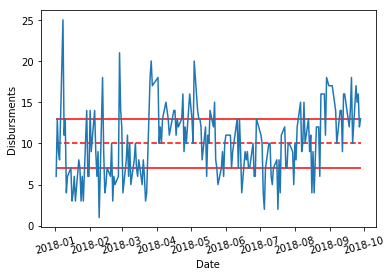

<Figure size 1440x720 with 0 Axes>

In [125]:
# Plot both time series for disbursements
sns.lineplot(x='disbursement_date', y='disbursements', data=jan_sep)
_ = plt.hlines(y=jan_sep['disbursements'].mean(), xmin=jan_sep['disbursement_date'].min(), 
              xmax=jan_sep['disbursement_date'].max(), linestyle='dashed', color='red')
_ = plt.hlines(y=jan_sep['disbursements'].quantile(0.75), xmin=jan_sep['disbursement_date'].min(), 
              xmax=jan_sep['disbursement_date'].max(), linestyle='solid', color='red')
_ = plt.hlines(y=jan_sep['disbursements'].quantile(0.25), xmin=jan_sep['disbursement_date'].min(), 
              xmax=jan_sep['disbursement_date'].max(), linestyle='solid', color='red')
_ = plt.xlabel('Date')
_ = plt.ylabel('Disbursments')
_ = plt.xticks(rotation=15)
_ = plt.figure(figsize=(20,10))
plt.show()

For this first plot, we're showing disbursments by day. I've also added the yearly mean (dashed red line) and both the 25th and 75th percentiles to serve as reference point to gauge how atypical each observation is. The highest number of disbursements came at the beginning of January and no other day came close to equalling the number of disbursments. However, January then sees a low point that lasts for a couple of weeks into February. From here the numbers stabilize a bit, with the pattern increasing until April, falling by July, and recovering into September.  
Let's check how these numbers look like for the amount disbursed. 

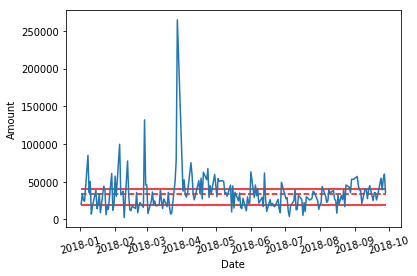

<Figure size 1440x720 with 0 Axes>

In [126]:
# Time series plot for amount disbursed. 
sns.lineplot(x='disbursement_date', y='disbursement_amount', data=jan_sep)
_ = plt.hlines(y=jan_sep['disbursement_amount'].mean(), xmin=jan_sep['disbursement_date'].min(), 
              xmax=jan_sep['disbursement_date'].max(), linestyle='dashed', color='red')
_ = plt.hlines(y=jan_sep['disbursement_amount'].quantile(0.75), xmin=jan_sep['disbursement_date'].min(), 
              xmax=jan_sep['disbursement_date'].max(), linestyle='solid', color='red')
_ = plt.hlines(y=jan_sep['disbursement_amount'].quantile(0.25), xmin=jan_sep['disbursement_date'].min(), 
              xmax=jan_sep['disbursement_date'].max(), linestyle='solid', color='red')
_ = plt.xlabel('Date')
_ = plt.ylabel('Amount')
_ = plt.xticks(rotation=15)
_ = plt.figure(figsize=(20,10))
plt.show()

This graph is way more interesting! We can see that, between April and September, the disbursement amount for each day is within the 25th and 75th percentile. But before April, we see that there are some very atypical disbursement observations, with the end of March featuring a total number of 250,000 Peruvian Soles (~84,000 US Dollars) being disbursed in a single day. 

#### Forecasting
We now have a good idea of how disbursements and disbursement amounts have changed through the year. We'll now use ARIMA to forecast the last three months of 2018. 

/home/martin/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/martin/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/martin/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

                               ARIMA Model Results                               
Dep. Variable:     D.disbursement_amount   No. Observations:                  188
Model:                    ARIMA(5, 1, 0)   Log Likelihood               -2170.645
Method:                          css-mle   S.D. of innovations          24941.484
Date:                   Mon, 04 Feb 2019   AIC                           4355.291
Time:                           18:21:47   BIC                           4377.946
Sample:                                1   HQIC                          4364.470
                                                                                 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          60.2633    564.468      0.107      0.915   -1046.073    1166.600
ar.L1.D.disbursement_amount    -0.7361      0.071    -10

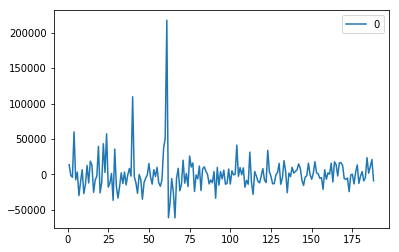

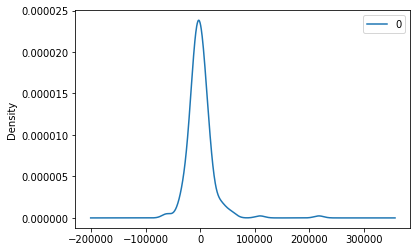

                   0
count     188.000000
mean      194.885121
std     25064.742942
min    -61398.818249
25%    -11838.227671
50%     -2168.514481
75%      7881.308520
max    217597.202405


In [127]:
# Build the ARIMA model, fit it, and print the summary and plots. 
model = ARIMA(jan_sep['disbursement_amount'], order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Looking at the results, we can see that constant has a very high p-value. The AIC is also high, reaching 4,355. But, looking at the first plot, the residuals seem to be very tightly knit, with exception to the spike that may be attributed to the large spike in the data set. The KDE plot shows, also, that the residual errors are following a Gaussian curve and centering around zero.  
Let's see how the model performs, forecasting on the oct_dec data set. 

In [172]:
# Start and end indexes for predicting the timestep
start_index = oct_dec.set_index('disbursement_date')
#end_index = oct_dec.iloc[62,0]
predict = model_fit.predict(start=start_index.iloc[0,0])
predict
# Append predictions to oct_dec
#start_index.index

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'